# Machine Learning Lab 9 - Arailym Kaiyrova

### Exercise 1: Implement Decision Tree

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

First started with loading the dataset, and assigning the corresponding columns

In [601]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'label']
df = pd.read_csv("iris.data", skiprows=1, header=None, names=col_names)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


Next is to separate the dataset into train and test sets according to given fraction, which is 0.8

In [602]:
def split_train_test(df, frac):
    train=df.sample(frac=frac,random_state=200) #random state is a seed value
    test=df.drop(train.index)
    return train, test

train_df, test_df = split_train_test(df, 0.8)

Below, there are the methods neccessary for building the decision tree. The function below is used for acquiring all possible splits in the dataset for each feature

In [784]:
def get_potential_splits(data):
    # Get all potential splits for all the columns of the data
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):        # excluding the last column which is the label
        potential_splits[column_index] = []
        values = data[:, column_index]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits

The method below splits the dataset into left and right datasets according to the threshold value from selected feature column

In [785]:
def split_data(data, split_column, split_value):
    # This function is useful in the splitting of a node given a feature attribute and the split value
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values >  split_value]
    
    return data_below, data_above

In [786]:
def compute_entropy(data):
    # This function computes the entropy of the label column
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

The mothod below is used for calculating information gain according to required quality criterion, which chooses either MCR or gini index. Implementation of gini index will be shown later

In [788]:
def calculate_split_entropy(data_below, data_above, mode):
    # This function computes the split entropy given the data going into the left and the right nodes
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n
    
    if mode=='gini':
        overall_entropy =  (p_data_below * gini_index(data_below) 
                      + p_data_above * gini_index(data_above))
    else:
        overall_entropy =  (p_data_below * compute_entropy(data_below) 
                      + p_data_above * compute_entropy(data_above))
    
    return overall_entropy

The function below is for finding the best split among all potential splits, and value for information gain

In [789]:
def determine_best_split(data, potential_splits, mode):
    # Complete the following function. This function determines the best split out of all the potential splits at a given point.
    # This function should return the index of the column which should be used for splitting and also the split value.
    best_split_column, best_split_value = None, None
    max_info_gain = -float("inf")
    #print(potential_splits)
    
    #potential_splits = get_potential_splits(data)
    for split_column in potential_splits:
        for split_value in potential_splits[split_column]:
            data_below, data_above = split_data(data, split_column, split_value)
            curr_info_gain = calculate_split_entropy(data_below, data_above, mode)
            
            if curr_info_gain>max_info_gain:
                max_info_gain = curr_info_gain
                best_split_column, best_split_value = split_column, split_value    
    return best_split_column, best_split_value


The method 'check_if_unique_class' is for checking if splitting the data left is still possible, if there are more than one unique classes

In [810]:
def check_if_unique_class(label_column):
    # This function returns True if data contains only one unique class
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

The method is for calculating leaf value accoring to left data, and distribute their probabilities among available classes, and plot their histogram

In [825]:
def unique_classes(data):
    # This function does simply return unique classes in the data
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
    
    prob = [x / len(label_column) for x in counts_unique_classes]
    
    hist = pd.DataFrame(prob).hist(bins=5)
    
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

This is the Node class for storing the tree node information, and if feature_name variable equals to 'leaf', it means that this is the leaf node, and 'split_value' contains leaf value instead of threshold value

In [826]:
class Node():
    def __init__(self, feature_name, feature_idx, split_value, left, right, depth):
        self.feature_name = feature_name
        self.feature_idx = feature_idx
        self.split_value = split_value
        self.left = left
        self.right = right
        self.depth = depth

Building the tree, which implemented recursively, which stops if data cannot be spliied further, or depth of the tree exceeds the maximum depth, which is 4 in this case

In [827]:
def dtree(df, mode, depth=0):
    if depth == 0:
        data = df.values
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
    else:
        data = df           
       
    # base cases
    if check_if_unique_class(data[:, -1]) or depth>4:
        classification = unique_classes(data)        
        feature_idx, feature_name, split_value = -1, 'leaf', classification
        node = Node(feature_name, feature_idx, split_value, None, None, depth)
        return node
    
    # recursive part
    else:    
        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, mode)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        left = dtree(data_below, mode, depth+1)
        right = dtree(data_above, mode, depth+1)
        node = Node(feature_name, split_column, split_value, left, right, depth)
        return node   

Results for simple MCR:

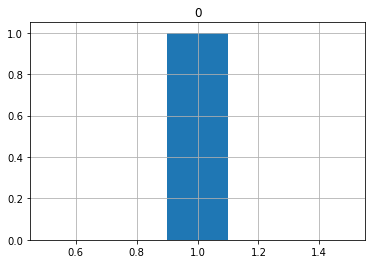

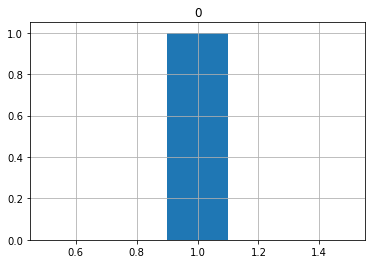

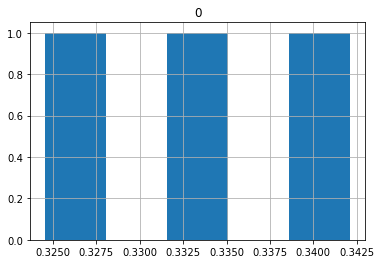

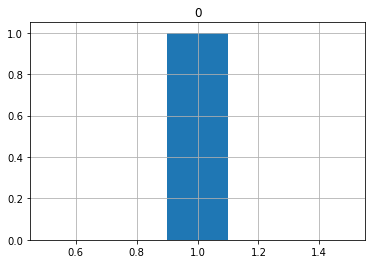

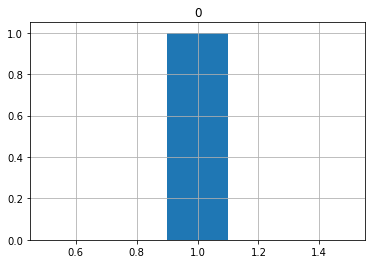

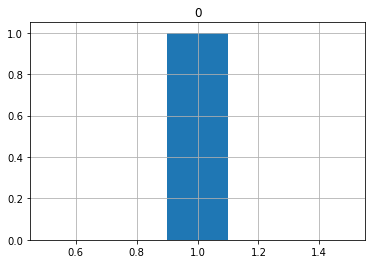

In [828]:
tree = dtree(train_df, 'entropy')

Level order traversal of the tree, or Breadth First Search Approach:

In [814]:
def height(node):
    if node is None:
        return 0
    else:
        # Compute the height of each subtree
        lheight = height(node.left)
        rheight = height(node.right)
 
        # Use the larger one
        if lheight > rheight:
            return lheight+1
        else:
            return rheight+1
        
# Print nodes at a current level
def printCurrentLevel(root, level, ind):
    if root is None:
        return
    if level == 1:
        print("{} <= {}".format(root.feature_name, root.split_value), level, 'side:',ind, 'depth: ',root.depth)
    elif level > 1:
        printCurrentLevel(root.left, level-1, 'left')
        printCurrentLevel(root.right, level-1, 'right')

def printLevelOrder(root):
    h = height(root)
    for i in range(1, h+1):
        printCurrentLevel(root, i, 'root')

In [815]:
printLevelOrder(tree)

sepal_length <= 4.35 1 side: root depth:  0
leaf <= Iris-setosa 1 side: left depth:  1
sepal_width <= 2.1 1 side: right depth:  1
leaf <= Iris-versicolor 1 side: left depth:  2
sepal_length <= 7.800000000000001 1 side: right depth:  2
sepal_width <= 4.1 1 side: left depth:  3
leaf <= Iris-virginica 1 side: right depth:  3
sepal_width <= 3.95 1 side: left depth:  4
leaf <= Iris-setosa 1 side: right depth:  4
leaf <= Iris-versicolor 1 side: left depth:  5
leaf <= Iris-setosa 1 side: right depth:  5


Making predictions for unseen data:

In [795]:
def predict(X, tree):
    preditions = [make_prediction(x, tree) for x in X]
    return preditions
    
def make_prediction(x, tree):
    if tree.feature_name == 'leaf': return tree.split_value
    feature_val = x[tree.feature_idx]
    if feature_val<=tree.split_value:
        return make_prediction(x, tree.left)
    else:
        return make_prediction(x, tree.right)

In [830]:
pred = predict(test_df.values, tree)
y_actual = test_df['label'].values
correct = 0
for i in range(len(pred)):
    if y_actual[i]==pred[i]: correct+=1
    print(y_actual[i], pred[i])
print('Accuracy: ', correct/len(pred))

Iris-setosa Iris-versicolor
Iris-setosa Iris-versicolor
Iris-setosa Iris-setosa
Iris-setosa Iris-versicolor
Iris-setosa Iris-versicolor
Iris-setosa Iris-versicolor
Iris-setosa Iris-setosa
Iris-setosa Iris-versicolor
Iris-setosa Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-versicolor Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Iris-virginica Iris-versicolor
Accuracy:  0.4


Implementation for gini index:

In [831]:
def gini_index(data):
    y = data[:, -1]
    class_labels = np.unique(y)
    gini = 0
    for cls in class_labels:
        p_cls = len(y[y == cls]) / len(y)
        gini += p_cls**2
    return 1 - gini

sepal_length <= 4.35 1 side: root depth:  0
leaf <= Iris-setosa 1 side: left depth:  1
sepal_width <= 2.1 1 side: right depth:  1
leaf <= Iris-versicolor 1 side: left depth:  2
sepal_length <= 7.800000000000001 1 side: right depth:  2
sepal_width <= 4.1 1 side: left depth:  3
leaf <= Iris-virginica 1 side: right depth:  3
sepal_width <= 2.25 1 side: left depth:  4
leaf <= Iris-setosa 1 side: right depth:  4
leaf <= Iris-versicolor 1 side: left depth:  5
leaf <= Iris-setosa 1 side: right depth:  5


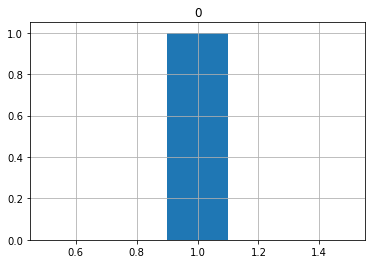

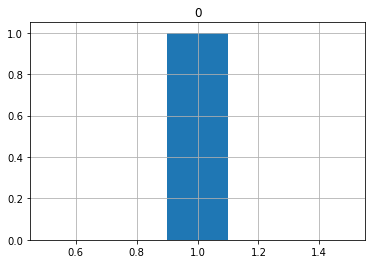

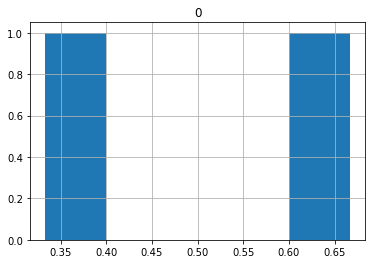

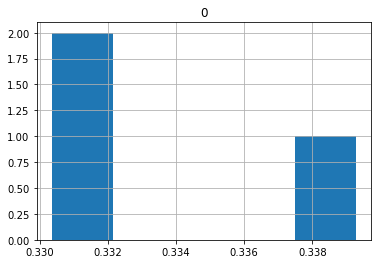

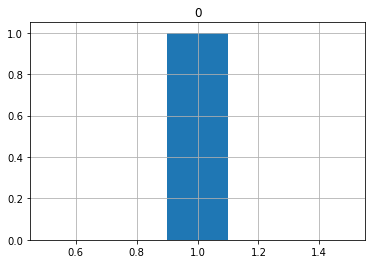

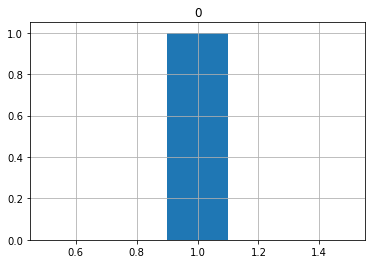

In [832]:
tree_gini = dtree(train_df, 'gini')
printLevelOrder(tree_gini)

In [833]:
pred_gini = predict(test_df.values, tree_gini)
print(pred_gini)

['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa']


In [834]:
y_actual = test_df['label'].values
correct = 0
for i in range(len(pred_gini)):
    if y_actual[i]==pred_gini[i]: correct+=1
    print(y_actual[i], pred_gini[i])
print('Accuracy: ', correct/len(pred_gini))

Iris-setosa Iris-setosa
Iris-setosa Iris-setosa
Iris-setosa Iris-setosa
Iris-setosa Iris-setosa
Iris-setosa Iris-setosa
Iris-setosa Iris-setosa
Iris-setosa Iris-setosa
Iris-setosa Iris-setosa
Iris-setosa Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-versicolor Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Iris-virginica Iris-setosa
Accuracy:  0.3


### Exercise 2: Gradient Boosted Decision Trees 

For this exercise we first need to create make moons datasets for 10 different noises, visualize them , them split them into train and test sets

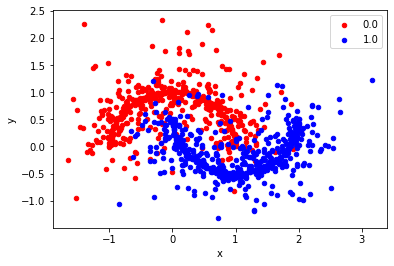

In [835]:
#Creating make moons dataset
from sklearn.datasets import make_moons
from matplotlib import pyplot
noises = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.001, 0.01, 0.25, 0.05]
X1, X2, y_comb = np.array([]), np.array([]), np.array([])
for noise in noises: 
    # generate 2d classification dataset
    X, y = make_moons(n_samples=100, noise=noise)
    X1 = np.append(X1, X[:,0])
    X2 = np.append(X2, X[:,1])
    y_comb = np.append(y_comb, y)
# scatter plot, dots colored by class value
df2 = pd.DataFrame(dict(x=X1, y=X2, label=y_comb))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df2.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [836]:
train_df_moon, test_df_moon = split_train_test(df2, 0.8)

Next we need to build decision tree that will be called during at each gradient boost iteration, which is similar to the previous excercise with slight modifications.\
\
In this implementation I used different approach for calculating leaf values, which instead of taking the value with highest probability, it takes takes some of residuals as numerator and divides it by the sum of (prev_probability)*(1-prev_probability), and takes it as gradient.\
Using this gradient and learning rate, which is 0.1, updates the current probalility

In [843]:
def update_leaf_values(data):
    # This function does simply return unique classes in the data
    num, denum = 0, 0
    for d in data:
        num+=d[4]
        denum+=(d[3]*(1-d[3]))
    w = num/denum
    
    for d in data:
        d[3] = d[3] + 0.1*w
        d[3] = (np.exp(d[3]))/(1+np.exp(d[3]))
    
    return data, w

In [844]:
def dtree2(df, mode, new_df, data = None, depth=0):
    if depth == 0:
        data = df.values
        global COLUMN_HEADERS, MAX_DEPTH
        COLUMN_HEADERS = df.columns 
        MAX_DEPTH = 2
    
    
    # base cases
    if check_if_unique_class(data[:, 4]) or depth>MAX_DEPTH:
        upd, val = update_leaf_values(data) 
        new_df.append(upd)
        feature_name, value = 'leaf', val
        node = Node(feature_name, -1, value, None, None, depth)
        return node

    
    # recursive part
    else:    
        # helper functions 
        potential_splits = get_potential_splits(data[:,[0,1,4]])
        split_column, split_value = determine_best_split(data[:,[0,1,4]], potential_splits, mode)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        left = dtree2(df, mode, new_df, data_below, depth+1)
        right = dtree2(df, mode, new_df, data_above, depth+1)
        node = Node(feature_name, split_column, split_value, left, right, depth)
        return node
    
    

Initial update done on train data by adding logistic probabilities, and residuals, which will be updated after each iteration

In [849]:
def update_df(df, initial_prob):
    df['prob'] = initial_prob
    df['prob'] = (np.exp(df['prob']))/(1+np.exp(df['prob']))
    df['resid'] =  df['prob'] - df['label']
    return df
    
counts = df2.groupby(['label']).count()
initial_prob = np.log2(counts.iloc[0,0]/counts.iloc[1,0])
train_df_moon = update_df(train_df_moon, initial_prob)
train_df_moon.head()


,x,y,label,prob,resid
674,0.981358,0.191063,0.0,0.5,0.5
233,1.028106,-0.375389,1.0,0.5,-0.5
739,-0.800262,0.602780,0.0,0.5,0.5
865,-0.222297,1.244070,0.0,0.5,0.5
523,2.151748,0.022382,1.0,0.5,-0.5


Function for training the data according to MAX_TREE size

In [847]:
def train_gbst(df, MAX_TREES):
    trees = []
    for i in range(MAX_TREES):
        arr = []
        tree = dtree2(df, 'gini', arr)
        trees.append(tree)
        print('Desicion tree after', i, 'th iteration:')
        printLevelOrder(tree)
        df_temp = pd.DataFrame([], columns=['x', 'y', 'label', 'prob', 'resid'])
        for row in arr:
            df_temp = df_temp.append(pd.DataFrame(row, columns=['x', 'y', 'label', 'prob', 'resid']))

        df = df_temp
        df['resid'] = df['prob'] - df['label']
    return trees
    

Training data according to given different train sizes, and predict the values for each unseen data according to the deciosion trees generated for each MAX_TREES size, and calculate accuracy

In [853]:
tree_counts = [1, 2, 5, 10]
for count in tree_counts:
    trees = train_gbst(train_df_moon, count)
    err = predict_find_error(test_df_moon, trees)
    print('Test error when maximum number of trees equal to', count, 'is:', err)

Desicion tree after 0 th iteration:
x <= -1.6166188496844422 1 side: root depth:  0
leaf <= 2.0 1 side: left depth:  1
x <= -1.5470927761383098 1 side: right depth:  1
leaf <= 2.0 1 side: left depth:  2
x <= -1.4927834102187312 1 side: right depth:  2
leaf <= 2.0 1 side: left depth:  3
leaf <= 0.04767879548306148 1 side: right depth:  3
Test error when maximum number of trees equal to 1 is: nan


<ipython-input-852-22c347fb58d0>:8: RuntimeWarning: divide by zero encountered in log
  loss+=-y_actual[i]*np.log(pred[i]) - (1-y_actual[i])*np.log(1-pred[i])
<ipython-input-852-22c347fb58d0>:8: RuntimeWarning: invalid value encountered in double_scalars
  loss+=-y_actual[i]*np.log(pred[i]) - (1-y_actual[i])*np.log(1-pred[i])


Desicion tree after 0 th iteration:
x <= -1.6166188496844422 1 side: root depth:  0
leaf <= 2.0 1 side: left depth:  1
x <= -1.5470927761383098 1 side: right depth:  1
leaf <= 2.0 1 side: left depth:  2
x <= -1.4927834102187312 1 side: right depth:  2
leaf <= 2.0 1 side: left depth:  3
leaf <= 0.04767879548306148 1 side: right depth:  3
Desicion tree after 1 th iteration:
y <= 2.289882187275003 1 side: root depth:  0
y <= 2.242194391736894 1 side: left depth:  1
leaf <= 2.6566009448690475 1 side: right depth:  1
y <= 2.1824732242610727 1 side: left depth:  2
leaf <= 2.6566009448690475 1 side: right depth:  2
leaf <= 0.5780944937758898 1 side: left depth:  3
leaf <= 2.6566009448690475 1 side: right depth:  3
Test error when maximum number of trees equal to 2 is: nan
Desicion tree after 0 th iteration:
x <= -1.6166188496844422 1 side: root depth:  0
leaf <= 2.0 1 side: left depth:  1
x <= -1.5470927761383098 1 side: right depth:  1
leaf <= 2.0 1 side: left depth:  2
x <= -1.4927834102187

Methods for predicting the output with given data, and trained model which is the sequnce of decision trees:

In [851]:
def predict_gbst(X, trees):
    final = [0.5]*len(X)
    for tree in trees:
        preditions = [make_prediction_gbst(x, tree) for x in X]
        final=np.add(final, preditions)
    for i in range(len(final)):
        if final[i]>=0.5: final[i] = 1
        else: final[i] = 0
    return final
    
def make_prediction_gbst(x, tree):
    if tree.feature_name == 'leaf': return 0.1*tree.split_value
    feature_val = x[tree.feature_idx]
    if feature_val<=tree.split_value:
        return make_prediction(x, tree.left)
    else:
        return make_prediction(x, tree.right)

In [854]:
def predict_find_error(test, trees):
    pred = predict_gbst(test.values, trees)
    y_actual = test['label'].values
    correct = 0
    for i in range(len(pred)):
        if y_actual[i]==pred[i]: correct+=1
    return correct/len(pred)